### Modeling Staten Island as a graph and finding the shortest paths

In [324]:
%matplotlib inline
import pandas as pd
import numpy as np
from transform_waze_raw_functions import *
import math
import matplotlib.pyplot as plt
import datetime
import geopandas as geo
import osmnx as ox
import geopy as gp
from ast import literal_eval
from jellyfish import jaro_winkler
from scipy.stats import boxcox
import matplotlib.colors as colors
import matplotlib.cm as cmx

Using python osmnx package, we can modeled Staten Island as a multi-directed graph. Each intersection is a node, and each portion of street between two intersections is an edge. Here is the result (edges are the gray lines and nodes are the blue points):

In [290]:
staten_island = ox.graph_from_place('Staten Island, New York City, New York, USA', network_type='drive', which_result=2)
staten_island_projected = ox.project_graph(staten_island)

Non-projected:


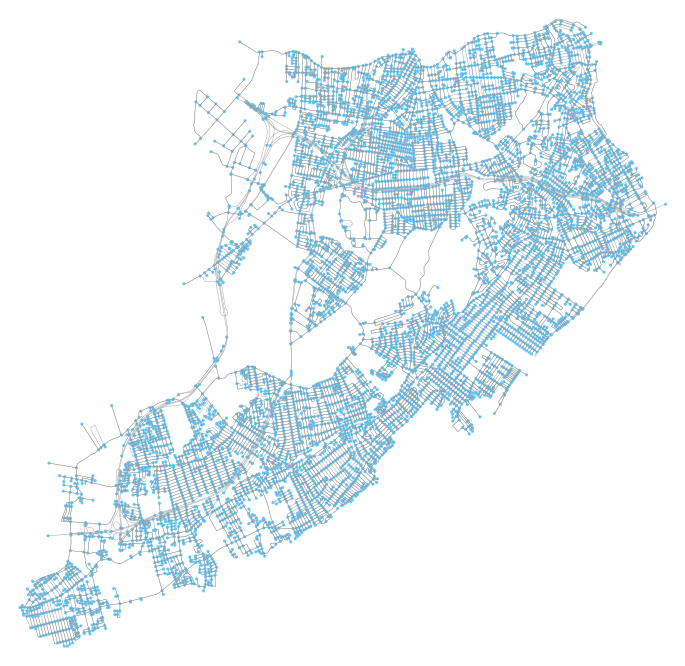

In [291]:
print('Non-projected:')
fig1, ax1 = ox.plot_graph(staten_island, fig_height=12,edge_linewidth=0.4, dpi=100, node_size=10)
fig1.savefig("image/graph.png")

Projected:


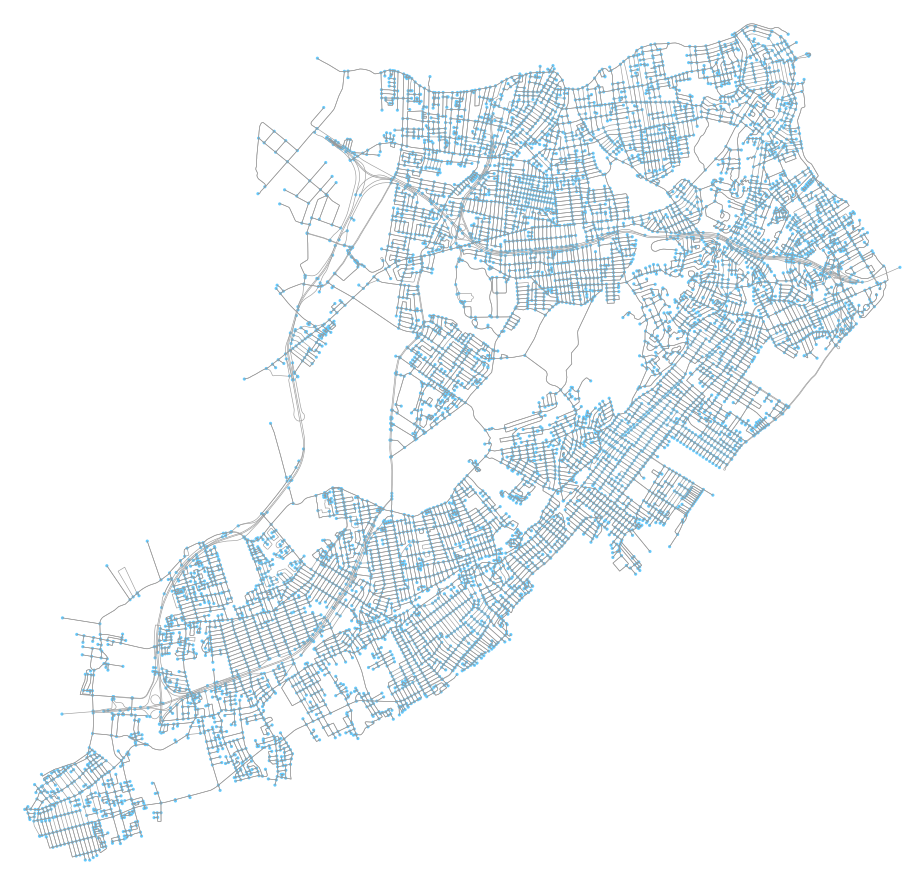

In [292]:
print('Projected:')
fig2, ax2 = ox.plot_graph(staten_island_projected, fig_height=16, node_size=10, 
              node_alpha=1,edge_linewidth=0.6, dpi=100)
fig2.savefig("image/projected_graph.png")

Representing Staten Island as a graph allows us to use Graph Theory and the optimization algorithms available to solve the congestion problems. We modeled the map of Staten Island as a weighted graph, where the weight on each edge was the cost of going through that edge, based on the number of jam alerts that were reported on that edge. We used this graph to formulate a shortest path problem to find the shortest path between any two given points - containing edges (or streets) that were the least jammed. Here, time is also really important, the jam distribution among Staten Island is not the same at 10am and 3pm for instance. So our shortest path problem becomes: Given two intersections A and B in Staten Island and a specific time slot, which path is the most likely to avoid jams?

To do this, first, we assigned weights to all the edges. The idea was to increment the weight for a given edge with each jam alert on that edge.

In [327]:
df = pd.read_csv('data/al_complete.csv')
df_jam = df[df['type'] == 'JAM'].reset_index(drop=True)
jm = transform_alerts(df_jam)
jm.location = jm.location.apply(literal_eval)
jm['hour'] = jm.pub_utc_date.str[11:13].astype(int)
jm_sample = jm.copy()
jm_sample = jm_sample[['location', 'street', 'hour']]
jm_sample = jm_sample.dropna()

In [328]:
jm_sample.head()

location                               street  \
0  {'x': -74.106248, 'y': 40.581721}                       N Railroad Ave   
1   {'x': -74.16563, 'y': 40.573204}                       Forest Hill Rd   
2  {'x': -74.174743, 'y': 40.621266}  Exit 5: NY-440 S / Outerbridge Xing   
3  {'x': -74.093446, 'y': 40.610587}                   Exit 13A: Clove Rd   
4  {'x': -74.112902, 'y': 40.611304}  Exit 12: Slosson Ave / Todt Hill Rd   

   hour  
0    15  
1    15  
2    15  
3    15  
4    15

For this purpose, we had to first somehow link the alerts to the edges. The Waze dataset provides us with the latitudes and longitudes for each alert (location). It also provides street names (street) for the locations of these alerts. The problem here was that the package we were using did not provide a function to link spatial coordinates to edges. What it did give us though, was a function to find the closest node (or intersection) given a pair of coordinates (using Euclidean distance under the hood).

In [17]:
ox.get_nearest_node(staten_island, (40.526118, -74.226031), method='euclidean')

42945952

We also extracted street names for edges using the osmnx package. For each intersection, we compared street names of the incoming and outgoing edges with the street name of the alert. Since the street names came from two different datasets, they were inconsistent and we did matching using Winckler Distance. After the matching, we incremented weights of the edges that had the same street name as the alert street name. We did this for each of our alerts and hence got weights for all of our edges.

In [297]:
def get_weight_graph(G, df, time):
    L1 = []
    L2 = []
    jm_sample = df[df['hour'] == time]
    for i in np.arange(jm_sample.shape[0]):
        row = jm_sample.iloc[i]
        if i%100 == 0:
            print(i, '/', len(jm_sample))
        lon = row['location']['x']
        lat = row['location']['y']
        road = row['street']
        node = ox.get_nearest_node(G, (lat, lon), method='euclidean')
        out_edges = G.out_edges(node)
        in_edges = G.in_edges(node)
        for j in out_edges:       
            if 'name' in G[j[0]][j[1]][0].keys():
                list_name = G[j[0]][j[1]][0]['name']
                if type(list_name) == str:
                    L = []
                    L.append(list_name)
                    list_name = L
                for name in list_name:
                    if (jaro_winkler(road, name) > 0.7):
                        L1.append(j[0])
                        L2.append(j[1])
  
        for j in in_edges:
            if 'name' in G[j[0]][j[1]][0].keys():
                list_name = G[j[0]][j[1]][0]['name']
                if type(list_name) == str:
                    L = []
                    L.append(list_name)
                    list_name = L
                for name in list_name:
                    if (jaro_winkler(road, name) > 0.7):
                        L1.append(j[0])
                        L2.append(j[1])
    return L1, L2

In [299]:
%%time
L1, L2 = get_weight_graph(staten_island, jm_sample, 15)

0 / 70717
100 / 70717
200 / 70717
300 / 70717
400 / 70717
500 / 70717
600 / 70717
700 / 70717
800 / 70717
900 / 70717
1000 / 70717
1100 / 70717
1200 / 70717
1300 / 70717
1400 / 70717
1500 / 70717
1600 / 70717
1700 / 70717
1800 / 70717
1900 / 70717
2000 / 70717
2100 / 70717
2200 / 70717
2300 / 70717
2400 / 70717
2500 / 70717
2600 / 70717
2700 / 70717
2800 / 70717
2900 / 70717
3000 / 70717
3100 / 70717
3200 / 70717
3300 / 70717
3400 / 70717
3500 / 70717
3600 / 70717
3700 / 70717
3800 / 70717
3900 / 70717
4000 / 70717
4100 / 70717
4200 / 70717
4300 / 70717
4400 / 70717
4500 / 70717
4600 / 70717
4700 / 70717
4800 / 70717
4900 / 70717
5000 / 70717
5100 / 70717
5200 / 70717
5300 / 70717
5400 / 70717
5500 / 70717
5600 / 70717
5700 / 70717
5800 / 70717
5900 / 70717
6000 / 70717
6100 / 70717
6200 / 70717
6300 / 70717
6400 / 70717
6500 / 70717
6600 / 70717
6700 / 70717
6800 / 70717
6900 / 70717
7000 / 70717
7100 / 70717
7200 / 70717
7300 / 70717
7400 / 70717
7500 / 70717
7600 / 70717
7700 / 7071

59400 / 70717
59500 / 70717
59600 / 70717
59700 / 70717
59800 / 70717
59900 / 70717
60000 / 70717
60100 / 70717
60200 / 70717
60300 / 70717
60400 / 70717
60500 / 70717
60600 / 70717
60700 / 70717
60800 / 70717
60900 / 70717
61000 / 70717
61100 / 70717
61200 / 70717
61300 / 70717
61400 / 70717
61500 / 70717
61600 / 70717
61700 / 70717
61800 / 70717
61900 / 70717
62000 / 70717
62100 / 70717
62200 / 70717
62300 / 70717
62400 / 70717
62500 / 70717
62600 / 70717
62700 / 70717
62800 / 70717
62900 / 70717
63000 / 70717
63100 / 70717
63200 / 70717
63300 / 70717
63400 / 70717
63500 / 70717
63600 / 70717
63700 / 70717
63800 / 70717
63900 / 70717
64000 / 70717
64100 / 70717
64200 / 70717
64300 / 70717
64400 / 70717
64500 / 70717
64600 / 70717
64700 / 70717
64800 / 70717
64900 / 70717
65000 / 70717
65100 / 70717
65200 / 70717
65300 / 70717
65400 / 70717
65500 / 70717
65600 / 70717
65700 / 70717
65800 / 70717
65900 / 70717
66000 / 70717
66100 / 70717
66200 / 70717
66300 / 70717
66400 / 70717
66500 

In [300]:
L3 = [1]*len(L1)
weight = pd.DataFrame({
    'node1':L1,
    'node2':L2,
    'count':L3
})

In [301]:
df_graph = weight.groupby(['node1', 'node2']).count().reset_index()
df_graph['cost'] = round(df_graph['count']/df_graph['count'].max()*100) + 1
df_graph['box'] = pd.Series(boxcox(df_graph['cost'])[0])

In [302]:
for i in staten_island.edges:
    if df_graph[(df_graph['node1'] == i[0]) & (df_graph['node2'] == i[1])].shape[0] > 0:
        staten_island.edges[i]['distance'] = df_graph[(df_graph['node1'] == i[0]) & (df_graph['node2'] == i[1])]['cost'].item()
    else:
        staten_island.edges[i]['distance'] = 0

In [303]:
for i in staten_island.edges:
    if df_graph[(df_graph['node1'] == i[0]) & (df_graph['node2'] == i[1])].shape[0] > 0:
        staten_island.edges[i]['box'] = df_graph[(df_graph['node1'] == i[0]) & (df_graph['node2'] == i[1])]['box'].item()
    else:
        staten_island.edges[i]['box'] = 0

In [315]:
weights = []
for i in staten_island.edges:
    weights.append(staten_island.edges[i]['box'])
cNorm  = colors.Normalize(vmin=min(df_graph['box']), vmax=max(df_graph['box']))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.cm.RdYlGn)
col = [scalarMap.to_rgba(min(df_graph['box']) + max(df_graph['box']) - k) for k in weights]

The final graph with normalised weights (using box-cox transformation) is as follows. It is plotted for the time-slot 3 PM - 4 PM, and the colors of the edges go from green to red as the weight increases. One problem here is that we are not able to track the traffic on the highways so efficiently because highways make really long edges and the closest nodes to alerts on highways are not necessarily the end points of the highways. This method would work well in a densely connected geometrical network - like that of Manhattan.

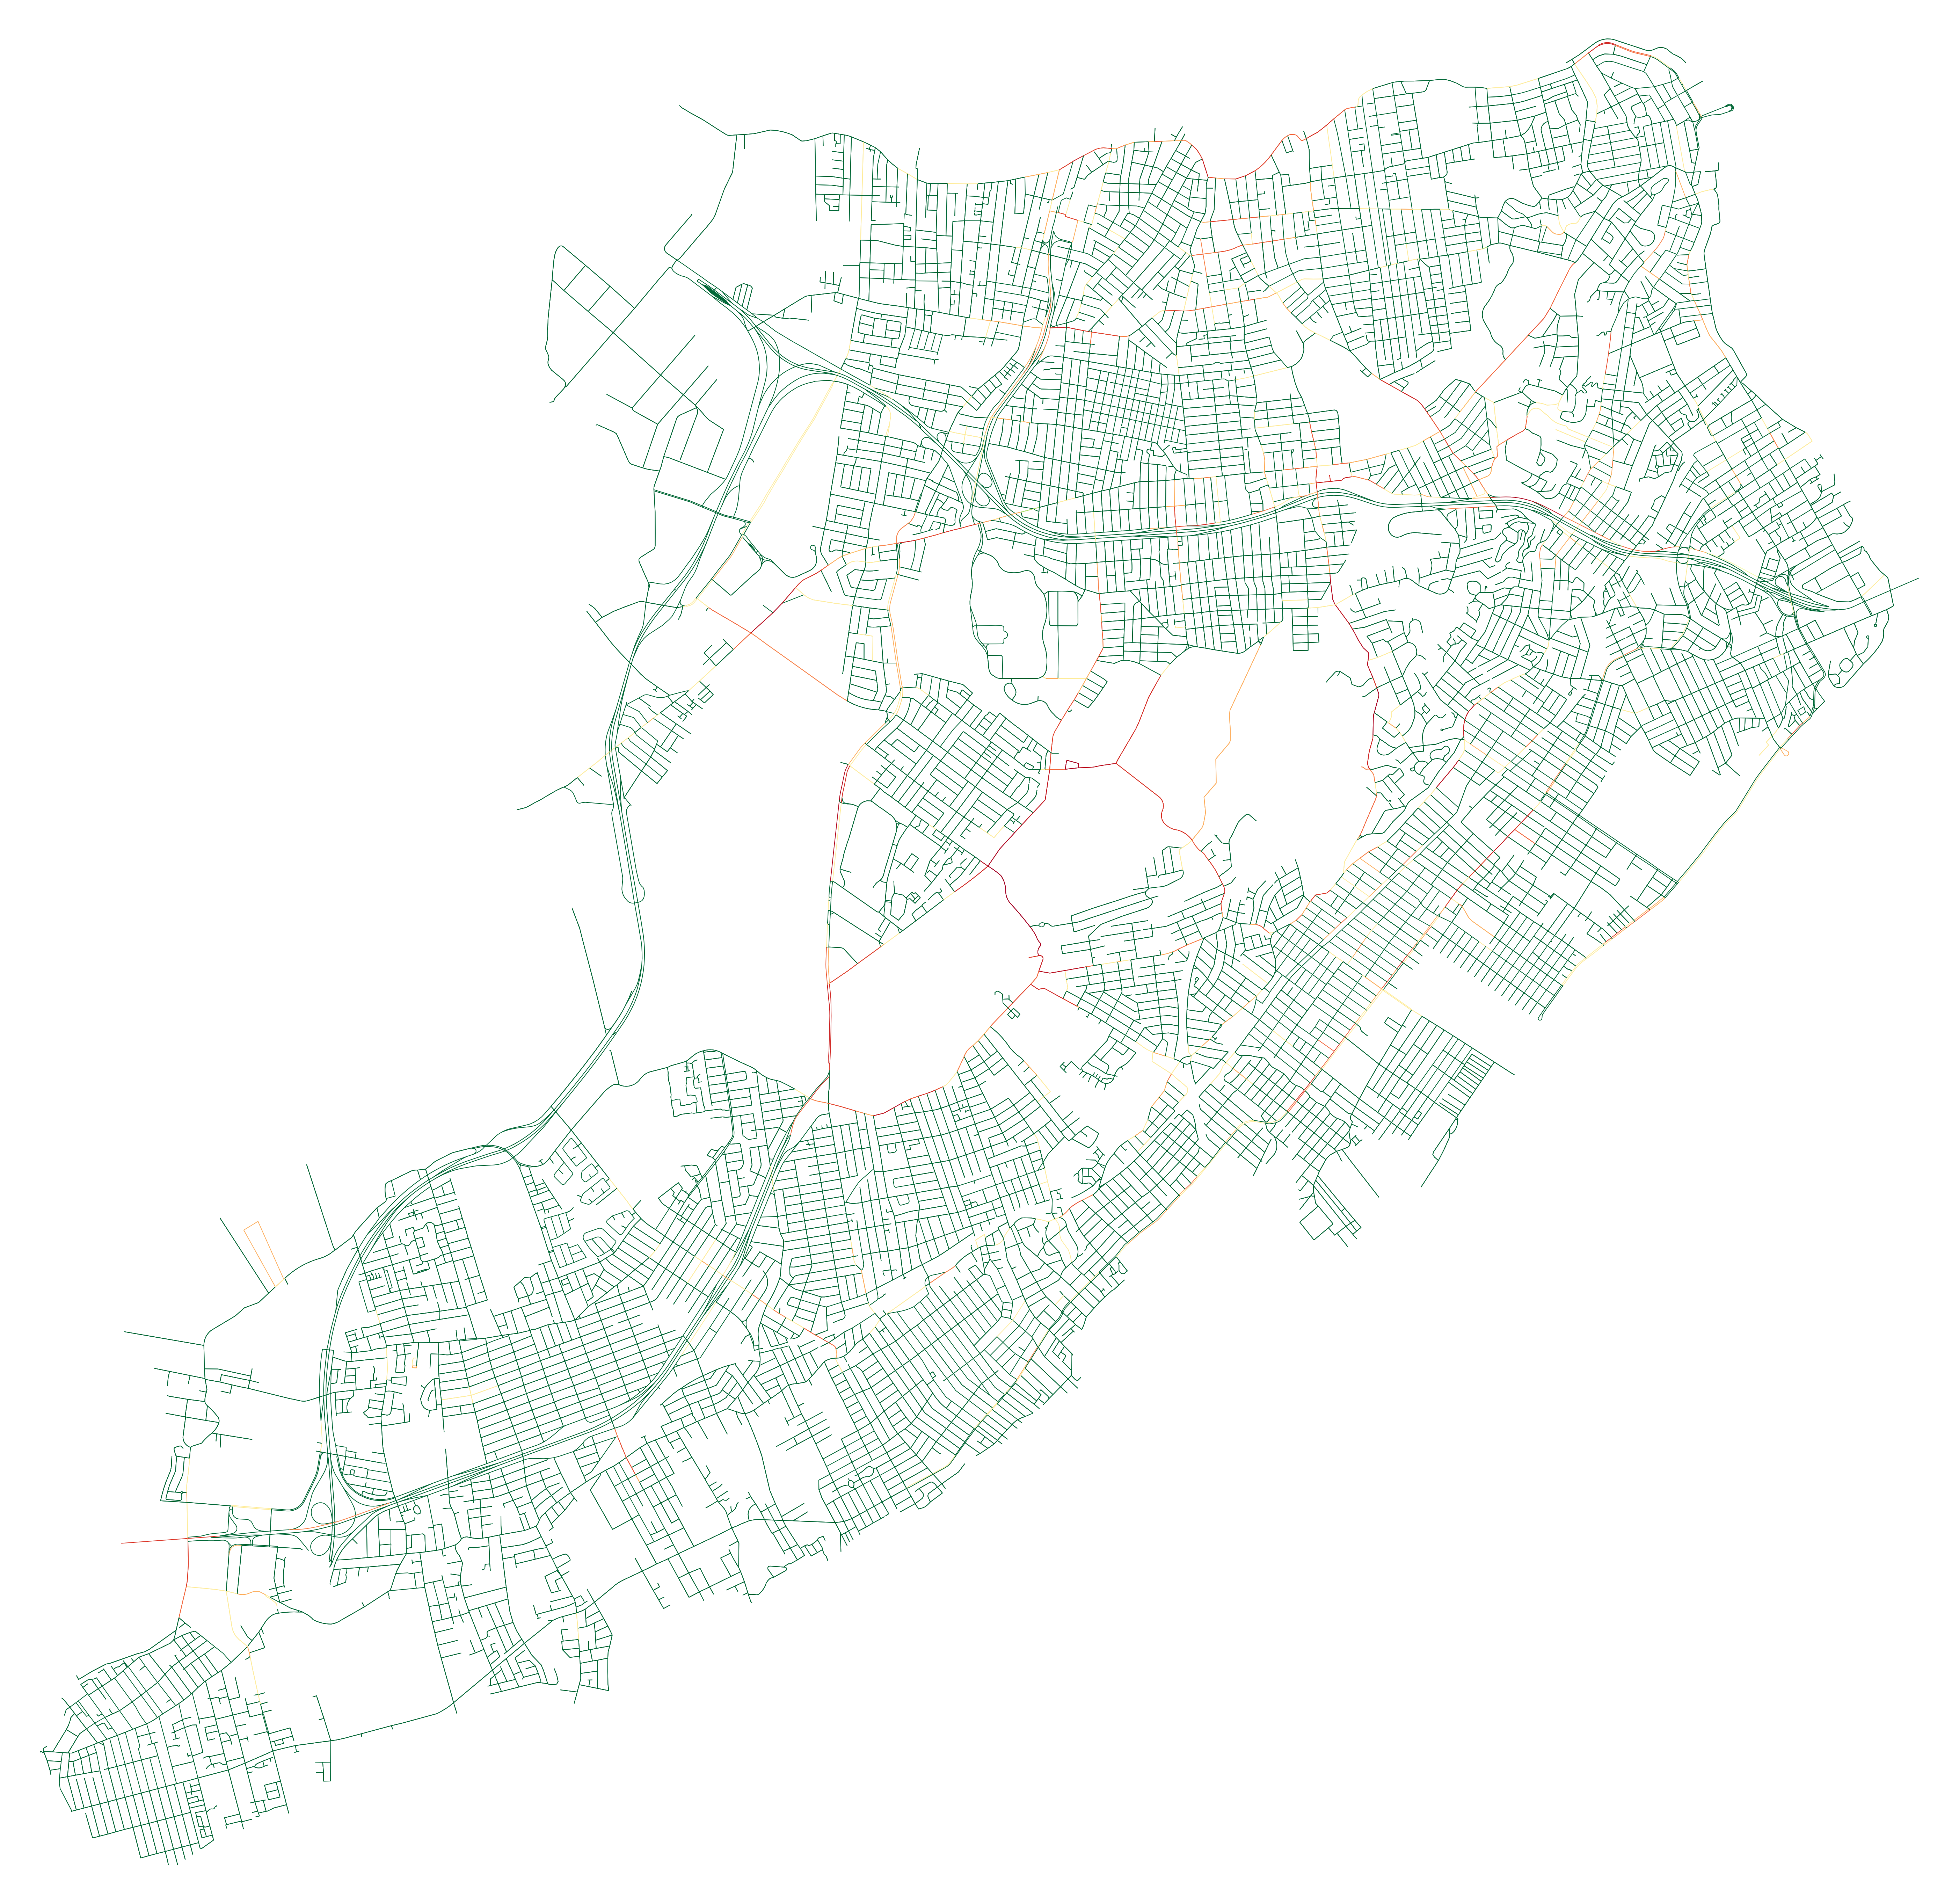

In [320]:
fig3, ax3 = ox.plot_graph(staten_island, fig_height=100,edge_linewidth=2, dpi=100, node_size=0.1, edge_color=col)

In [322]:
fig3.savefig("image/weighted_graph.png")

In [41]:
def get_highway(G, df, time):
    L1 = []
    L2 = []
    jm_sample = df[df['hour'] == time]
    for i in np.arange(jm_sample.shape[0]):
        row = jm_sample.iloc[i]
        if i%100 == 0:
            print(i, '/', len(jm_sample))
        lon = row['location']['x']
        lat = row['location']['y']
        road = row['street']
        node = ox.get_nearest_node(G, (lat, lon), method='euclidean')
        out_edges = G.out_edges(node)
        in_edges = G.in_edges(node)
        for j in out_edges:   
            if G[j[0]][j[1]][0]['highway'] == 'motorway_link':
                print(G[j[0]][j[1]][0])

Our next step towards this would be to create composite weights for each edge considering the distance, speed limit and the number alerts (of any type).


In [16]:
si = ox.core.add_edge_lengths(staten_island)